In [501]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nusretkizilaslan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nusretkizilaslan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [502]:
def convert_to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    special_characters_to_be_removed = ["'", ",", "*", "_", "(", ")", "/", "&", "%", "+", "^", ";", "=", "\\", "-", "%",'"',".",":",">","?","!"]    
    cleaned_text = ''
    # Removing special characters from the text
    for char in text:
        if char in special_characters_to_be_removed:
            cleaned_text += ' '
        else:
            cleaned_text += char


    return cleaned_text

def tokenize(text):
    return word_tokenize(text) 


def remove_stopwords(wordlist):
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in wordlist if word.lower() not in stop_words]
    return filtered_words

def stemming(wordlist):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in wordlist]
    return stemmed_words

def convert_list_to_string(wordlist):
    review = ""
    for word in wordlist:
        review = review + word + " "
    return review

def clean_text(text):
    # Lowercase
    cleaned = convert_to_lowercase(text)

    # Remove punctuation and special characters
    cleaned = remove_special_characters(cleaned)

    wordlist = tokenize(cleaned)

    # Stopword removal
    wordlist = remove_stopwords(wordlist)
    
    # Stemming
    wordlist = stemming(wordlist)

    cleaned_text = convert_list_to_string(wordlist)

    return cleaned_text

In [503]:
data_path = "./project-material/dataset/dataset/*.html" #Herkes kendi bilgisayarına uygun olarak değiştirsin.

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:06<00:00, 21.03it/s]


In [504]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [505]:
prompts = []
code_and_length = dict()
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            cleaned_convo = clean_text(conv["text"])
            prompts.append(cleaned_convo)
            user_prompts.append(cleaned_convo)
    code_and_length[code] = len(user_prompts)
    code2prompts[code] = user_prompts    


In [506]:
prompts[3]


'alreadi provid code pleas recreat part shuffl need 1 shuffl datafram name df 2 separ dataset featur matrix x target vector column health metric column includ x 3 split data train test set 80 data train 20 test ensur split random '

In [507]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing
Understanding the Dataset:
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

* Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
- Re-train model with the hyperparameters you have chosen in part 5).
- Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
- Predict the labels of testing data using the tree you have trained in step 6.
- Report the classification accuracy.
- Plot & investigate the confusion matrix. Fill the following blanks.
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split""",
#####################
]

**Questions Cleaning**

In [508]:

questions_cleaned = []

for question in questions:
    cleaned_question  = clean_text(question)
    questions_cleaned.append(cleaned_question)

questions_cleaned

['initi first make copi notebook given starter make sure choos connect form upper right may upload data section left colab right click csv file get path file click copi path use load data ',
 'load train dataset read csv file panda librari ',
 'understand dataset preprocess understand dataset find shape dataset number sampl number attribut hint use shape function display variabl name depend independ display summari dataset hint use info function display first 5 row train dataset hint use head function preprocess check miss valu dataset either drop valu fill common valu correspond row care enough data train model encod categor label map given cell hint use map function ',
 'set x split data shuffl dataset seper depend variabl x independ variabl column health metric rest x split train test set 80 20 respect ',
 'featur correl correl featur health calcul correl featur dataset highlight strong correl target variabl plot result heatmap featur select select subset featur like strong predicto

In [509]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions_cleaned)

In [510]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions_cleaned).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF


00000  000000  000196  000282  000284  000360  000469  000750  000886  \
0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   000991  001  001565  001611  001650  002  002349  002356  002538  002973  \
0     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
1     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
2     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
3     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
4     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
5     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
6     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
7     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
8     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   

   002993  003113  003152  003745  004371  004383  004494  004674  005  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
5     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   

   005252  006045  006090  006114  006390709664823  006497  007209  007300  \
0     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
5     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
6     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
7     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
8     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   

   008015  008250  008381  008396  008586  008685  008835  008984  009305  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   009475  00m   01  010  010127  010174  010484  010548  010767  010782  \
0     0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     

In [511]:
code2prompts_tf_idf = dict()
print(len(code2prompts))
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

print(len(code2prompts_tf_idf.keys()))

127
139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
123


In [512]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

00000  000000  000196  000282  000284  000360  000469  000750  000886  \
0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   000991  001  001565  001611  001650  002  002349  002356  002538  002973  \
0     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
1     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
2     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
3     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   
4     0.0  0.0     0.0     0.0     0.0  0.0     0.0     0.0     0.0     0.0   

   002993  003113  003152  003745  004371  004383  004494  004674  005  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   

   005252  006045  006090  006114  006390709664823  006497  007209  007300  \
0     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0              0.0     0.0     0.0     0.0   

   008015  008250  008381  008396  008586  008685  008835  008984  009305  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   009475  00m   01  010  010127  010174  010484  010548  010767  010782  \
0     0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   011001  011340  011463  011506  011599  012049  012634  012682  012986  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   013088  015288  015372  015424  015510  015739  016385478260275615  \
0     0.0     0.0     0.0     0.0     0.0     0.0                 0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0                 0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0                 0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0                 0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0                 0.0   

   016385478260275674  016508  016566  016685  016860  017632  018789  019  \
0                 0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
1                 0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
2                 0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0   
3                 0.0  

In [513]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 3730)

In [514]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [515]:
questions[4]

"Features and Correlations\n\n* Correlations of features with health\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [516]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions_cleaned))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)



question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.145836,0.411039,0.647314,0.432466,0.530333,0.644238,0.164639,0.191949,0.147481
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.164412,0.820935,0.784665,0.863107,0.655245,0.970891,0.693906,0.716859,0.588288
2,041f950b-c013-409a-a642-cffff60b9d4b,0.104582,0.203120,0.457470,0.309111,0.620128,0.324409,0.420149,0.500536,0.173267
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.060780,0.153073,0.185556,0.408085,0.542088,0.349459,0.536529,0.301697,0.380870
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.320294,0.635562,0.796448,0.658152,0.701968,0.907224,0.524200,0.876157,0.575533
5,090d6217-5d69-4929-a342-19abab78324f,0.148445,0.741208,0.650356,0.658152,0.730782,0.907224,0.679984,0.801826,0.907281
6,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,0.292854,0.469932,0.694506,0.760032,0.793807,0.858112,0.872497,0.901715,0.508935
7,0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc,0.042871,0.113560,0.181385,0.174471,0.196760,0.068764,0.363603,0.412233,0.129106
8,0e466794-f7f8-4cc2-b07e-070b13a0b5e1,0.132179,0.525091,0.844024,0.325019,0.701968,0.970891,0.693906,0.885411,0.738396
9,0f0c953a-a472-47c1-809b-9fc14dba9091,0.072010,0.172435,0.324218,0.460478,0.730782,0.994452,0.940916,0.323984,0.183774


In [517]:
threshold = 0.5

# Length of the chat


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [518]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "entropy", "impurity"]
keywords2search = [k.lower() for k in keywords2search]


for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                if kw == "impurity" :
                    code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))    

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)
            impurity_response_count = len(re.findall(rf"\b{kw}\b", text))
            code2features[code]['#response_impurity'] = impurity_response_count

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [519]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,prompt_avg_chars,response_avg_chars,#response_impurity
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,2.205748,212.206370,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.304163,113.633582,0.0
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.262324,17.187601,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.123346,107.092566,0.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,0.017986,18.850913,0.0


In [520]:
# reading the scores
scores = pd.read_csv("./project-material/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


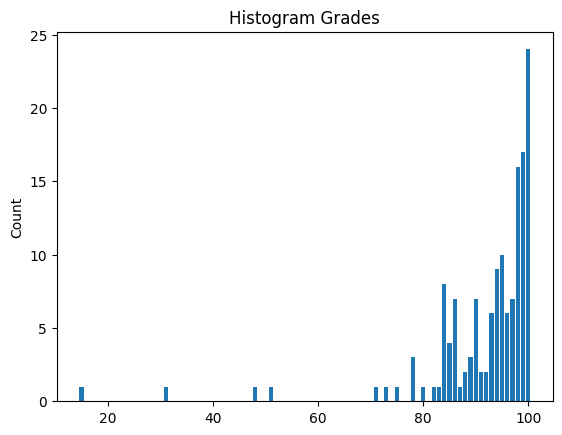

In [521]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [522]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,prompt_avg_chars,response_avg_chars,#response_impurity
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,2.205748,212.206370,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.304163,113.633582,0.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.262324,17.187601,0.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.123346,107.092566,0.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,0.017986,18.850913,0.0


In [523]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,prompt_avg_chars,response_avg_chars,#response_impurity,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,2.205748,212.206370,0.0,0.145836,0.411039,0.647314,0.432466,0.530333,0.644238,0.164639,0.191949,0.147481
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.304163,113.633582,0.0,0.164412,0.820935,0.784665,0.863107,0.655245,0.970891,0.693906,0.716859,0.588288
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.262324,17.187601,0.0,0.104582,0.203120,0.457470,0.309111,0.620128,0.324409,0.420149,0.500536,0.173267
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.123346,107.092566,0.0,0.060780,0.153073,0.185556,0.408085,0.542088,0.349459,0.536529,0.301697,0.380870
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,0.017986,18.850913,0.0,0.320294,0.635562,0.796448,0.658152,0.701968,0.907224,0.524200,0.876157,0.575533


#### Merging scores with features

In [524]:
# Your code
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code", inplace=True, keep="first")

# Display the entire DataFrame
temp_df


,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,prompt_avg_chars,response_avg_chars,#response_impurity,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,2.205748,212.206370,0.0,0.145836,0.411039,0.647314,0.432466,0.530333,0.644238,0.164639,0.191949,0.147481,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.304163,113.633582,0.0,0.164412,0.820935,0.784665,0.863107,0.655245,0.970891,0.693906,0.716859,0.588288,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.262324,17.187601,0.0,0.104582,0.203120,0.457470,0.309111,0.620128,0.324409,0.420149,0.500536,0.173267,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.123346,107.092566,0.0,0.060780,0.153073,0.185556,0.408085,0.542088,0.349459,0.536529,0.301697,0.380870,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,0.017986,18.850913,0.0,0.320294,0.635562,0.796448,0.658152,0.701968,0.907224,0.524200,0.876157,0.575533,100.0
5,090d6217-5d69-4929-a342-19abab78324f,73.0,13.0,0.0,0.0,0.0,19.0,0.0,0.006570,26.744905,0.0,0.148445,0.741208,0.650356,0.658152,0.730782,0.907224,0.679984,0.801826,0.907281,84.0
7,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.380935,186.805893,0.0,0.292854,0.469932,0.694506,0.760032,0.793807,0.858112,0.872497,0.901715,0.508935,96.0
8,0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc,11.0,0.0,0.0,0.0,0.0,1.0,0.0,0.379206,75.604962,0.0,0.042871,0.113560,0.181385,0.174471,0.196760,0.068764,0.363603,0.412233,0.129106,80.0
9,0e466794-f7f8-4cc2-b07e-070b13a0b5e1,46.0,6.0,0.0,0.0,0.0,3.0,0.0,0.006671,78.077540,0.0,0.132179,0.525091,0.844024,0.325019,0.701968,0.970891,0.693906,0.885411,0.738396,89.0
10,0f0c953a-a472-47c1-809b-9fc14dba9091,17.0,3.0,0.0,0.0,1.0,0.0,0.0,0.302888,45.073739,0.0,0.072010,0.172435,0.324218,0.460478,0.730782,0.994452,0.940916,0.323984,0.183774,83.0


In [525]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 19) (122,)


#### Train/Test split

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

**Neural Network (Nusret)**

In [527]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

list_of_ones = [1] * 19
weights = [9,1,1,1,1,1,1.0,1.7,1,1,1.3,1,1.05,1.0,1.15,1.20,1.5,2,1.20]
X_weighted = temp_df[temp_df.columns[1:-1]].to_numpy() * weights   

X_train, X_test, y_train, y_test = train_test_split(X_weighted, y, test_size=0.2, random_state=42)


print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

(122, 19) (122,)
Train set size: 97
Test set size: 25


In [528]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Epoch 1/50


3/3 [==============================] - 0s 28ms/step - loss: 8543.6230 - val_loss: 8753.4014
Epoch 2/50
3/3 [==============================] - 0s 6ms/step - loss: 8476.4082 - val_loss: 8706.5029
Epoch 3/50
3/3 [==============================] - 0s 7ms/step - loss: 8414.8945 - val_loss: 8655.9121
Epoch 4/50
3/3 [==============================] - 0s 7ms/step - loss: 8358.0244 - val_loss: 8599.4102
Epoch 5/50
3/3 [==============================] - 0s 7ms/step - loss: 8306.1318 - val_loss: 8535.7490
Epoch 6/50
3/3 [==============================] - 0s 6ms/step - loss: 8236.0713 - val_loss: 8461.2480
Epoch 7/50
3/3 [==============================] - 0s 7ms/step - loss: 8142.5444 - val_loss: 8373.2119
Epoch 8/50
3/3 [==============================] - 0s 7ms/step - loss: 8038.1489 - val_loss: 8268.9160
Epoch 9/50
3/3 [==============================] - 0s 6ms/step - loss: 7927.2285 - val_loss: 8145.3633
Epoch 10/50
3/3 [==============================] - 0s 7ms/step - loss: 7815.1968 - val_loss:

In [529]:
index_to_predict = -10
print(y_test)
# Access the specific input from the test set
input_to_predict = X_test[index_to_predict, :]

# If you used scaling during training, apply the same scaling to the input
input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))

prediction = model.predict(input_to_predict_scaled)

print(f"Actual Grade: {y_test[index_to_predict]}")
print(f"Predicted Grade: {min(prediction[0][0],100)}")

[ 96.  91.  97.  88. 100.  97. 100.  95.  94.  90.  86.  98.  94.  78.
  98. 100.  86.  97.  90.  48.  87. 100.  99. 100.  94.]
1/1 [==============================] - 0s 11ms/step
Actual Grade: 100.0
Predicted Grade: 62.32755661010742


**SVM (Berenay)**

In [530]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming 'X' contains your features and 'y' contains the target variable ('grade')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVR model
model = SVR(kernel='linear')  # You can experiment with different kernels, such as 'linear', 'rbf', etc.
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 121.3482384040448


**Random Forest (Kağan)**

In [531]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

list_of_ones = [1] * 19
weights = [1,1,1,1,1,20,90,1.3,1,1,1.3,1,1,1.15,0,1.20,1.15,1.20,1.10]

X_weighted = temp_df[temp_df.columns[1:-1]].to_numpy() * weights

X_train, X_test, y_train, y_test = train_test_split(X_weighted, y, test_size=0.2, random_state=42)


print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

(122, 19) (122,)
Train set size: 97
Test set size: 25


In [532]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# Create and train the Random Forest model
forest_model = RandomForestRegressor()  # Experiment with different values


forest_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_forest = forest_model.predict(X_test)

# Evaluate the Random Forest model
mse_forest = mean_squared_error(y_test, predictions_forest)
print(f'Mean Squared Error (Random Forest): {mse_forest}')


Mean Squared Error (Random Forest): 99.07048000000003


In [533]:
# Assuming 'X_test' contains your test set and 'forest_model' is your trained Random Forest model

print(y_test)

# Choose the index of the input you want to predict
index_to_predict = -2  # Replace with the index you're interested in

# Access the specific input from the test set
input_to_predict = X_test[index_to_predict, :]

# If you used scaling during training, apply the same scaling to the input
input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))

# Use the trained Random Forest model to make predictions
prediction = forest_model.predict(input_to_predict_scaled)

print(f"Actual Grade: {y_test[index_to_predict]}")
print(f"Predicted Grade: {prediction[0]}")


[ 96.  91.  97.  88. 100.  97. 100.  95.  94.  90.  86.  98.  94.  78.
  98. 100.  86.  97.  90.  48.  87. 100.  99. 100.  94.]
Actual Grade: 100.0
Predicted Grade: 82.75


**Gradient Boost (Ali)**

In [534]:
# Bazı feeaturelara bias ekledim. bu sayede daha accurate sonuç veriyo
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

list_of_ones = [0] * 19
weights = [1,1,1,1,1,20,90,1.3,1,1,1.3,1,1,1.15,0,1.20,1.15,1.20,1.10]

X_weighted = temp_df[temp_df.columns[1:-1]].to_numpy() * weights

X_train, X_test, y_train, y_test = train_test_split(X_weighted, y, test_size=0.2, random_state=42)


print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

(122, 19) (122,)
Train set size: 97
Test set size: 25


In [551]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Assuming 'X' contains your features and 'y' contains the target variable ('grade')
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
# Mean Squared Error on test set: 98.0395036389909
 
 

# Create and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=99, learning_rate=0.01, random_state=42, max_depth=3, subsample=0.8,min_samples_split=10, min_samples_leaf=4)


print(X_train.shape)

# Define sample weights for each feature in each entry
# Burayı görmezden gelin
#single_sample_weight = np.array([3, 1, 1, 1, 1, 1, 1.2, 1.3, 1, 1, 1.3, 1, 1.05, 1.15, 0, 1.20, 1.15, 2.0, 1.10])





gb_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_gb = gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
mse_gb = mean_squared_error(y_test, predictions_gb)
print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')

# Choose an index from X_test to test a specific data point
index_to_test = -4  # You can change this to the index you want to test

# Get the features of the specific data point
features_to_test = X_test[index_to_test, :].reshape(1, -1)

# Get the real target value for the specific data point
real_value = y_test[index_to_test]

# Make predictions for the specific data point
predicted_value = gb_model.predict(features_to_test)[0]

print(f"Real Value: {real_value}")
print(f"Predicted Value: {predicted_value}")

(97, 19)
[[3.   1.   1.   ... 1.15 2.   1.1 ]
 [3.   1.   1.   ... 1.15 2.   1.1 ]
 [3.   1.   1.   ... 1.15 2.   1.1 ]
 ...
 [3.   1.   1.   ... 1.15 2.   1.1 ]
 [3.   1.   1.   ... 1.15 2.   1.1 ]
 [3.   1.   1.   ... 1.15 2.   1.1 ]]


ValueError: Sample weights must be 1D array or scalar

**Decision Tree (Mert)**

In [543]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

weights = [3,1,1,1,1,1,1.2,1.3,1,1,1.3,1,1.05,1.15,0,1.20,1.15,2.0,1.10]
X_weighted = temp_df[temp_df.columns[1:-1]].to_numpy() * weights

X_train, X_test, y_train, y_test = train_test_split(X_weighted, y, test_size=0.2, random_state=42)


print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

(122, 19) (122,)
Train set size: 97
Test set size: 25


In [544]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create and train the Decision Tree model
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_tree = tree_model.predict(X_test)

# Evaluate the Decision Tree model
mse_tree = mean_squared_error(y_test, predictions_tree)
print(f'Mean Squared Error (Decision Tree): {mse_tree}')

Mean Squared Error (Decision Tree): 119.68


#### Predicting and Analyzing 

In [538]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [539]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 118.06243496358093
Node 4 has MSE 148.79338842975267
Node 5 has MSE 61.649999999999636
Node 6 has MSE 30.77551020408282
Node 7 has MSE 12.6875
Node 8 has MSE 4.66666666666697
Node 9 has MSE 0.0
Node 10 has MSE 0.25
Node 11 has MSE 0.0
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 4.222222222222626
Node 15 has MSE 0.0
Node 16 has MSE 1.0
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 22.222222222224445
Node 20 has MSE 0.0
Node 21 has MSE 0.0
Node 22 has MSE 0.0
Node 23 has MSE 55.88750000000073
Node 24 has MSE 28.691358024692818
Node 25 has MSE 19.49609375
Node 26 has MSE 22.75
Node 27 has MSE 0.22222222222262644
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 8.960000000000946
Node 31 has MSE 0.0
Node 32 has MSE 2.75
Node 33 has MSE 0.0
Node 34 has MSE 1.0
Node 35 has MSE 3.109375
Node 36 has MSE 0.23999999999978172
Node 37 has MSE 0.0
Node 38 h

In [540]:
# Plotting the Tree 
# dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
# graph = graphviz.Source(dot_data)
# graph.render("hw")

In [541]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 2.1528522336769758
MSE TEST: 96.32064
R2 Train: 0.9868262897729958
R2 TEST: 0.1420289028874383
